# Setup

In [1]:
# Overcooked AI imports
from overcooked_ai_py.agents.agent import *
from overcooked_ai_py.agents.benchmarking import AgentEvaluator
from overcooked_ai_py.mdp.overcooked_env import OvercookedEnv, Overcooked
from overcooked_ai_py.mdp.overcooked_mdp import OvercookedGridworld
from overcooked_ai_py.mdp.actions import Action
from overcooked_ai_py.visualization.state_visualizer import StateVisualizer

# Tensorflow imports
import tensorflow as tf
from keras.models import Model 
from keras.layers import Dense, Input, LayerNormalization, Conv2D, GlobalAveragePooling2D
from keras.optimizers import Adam, AdamW
from keras.src.models.functional import Functional
from keras.losses import SparseCategoricalCrossentropy, MeanSquaredError

# Utils imports
import random as rnd
import numpy as np
from sklearn.utils import shuffle 
import imageio.v2 as imageio
from matplotlib import pyplot as plt
from itertools import accumulate
from typing_extensions import override
from typing import abstractmethod

# Allow Reproducibility

In [2]:
random_seed = 42
rnd.seed(random_seed)
np.random.seed(random_seed)

# Global Variables

In [3]:
HORIZON = 400
OBSERVATION_LENGTH = 96
NUM_ACTIONS = Action.NUM_ACTIONS

# Canonical
gamma = 0.99
lam = 0.98
EPS = 1e-8
CLIP_EPS = 0.2
entropy_bonus_weight = 0.01
max_gradient_norm = 0.5

sparse_reward_decay_rate = 0.001
min_shaped_reward = 0.2
policy_lr = 1e-3
value_lr = 1e-3

# Debug and Visualization
save_gif = True
save_frequency = 100 # expressed in epochs

# Experimental Variables 
EXP_STEPS = 1600
EXP_EPOCHS = 120 #approx. 30 min for 30.000 params
EXP_BATCH_SIZE = 256
EPISODES_PER_EPOCH = EXP_STEPS // HORIZON

# Global Functions

In [ ]:
class MyNNPolicy(NNPolicy):
    def __init__(self, policy: Functional, base_env: OvercookedEnv):
        super().__init__()
        self.policy = policy
        self.env = base_env
    
    def multi_state_policy(self, states, agent_indices):
        probs = []
        for state, agent_idx in zip(states, agent_indices):
            featurized_state = self.env.featurize_state_mdp(state)
            
            probs.append(self.policy.predict(featurized_state[agent_idx].reshape((1,OBSERVATION_LENGTH)),verbose=0)[0])
        return probs
    
    def multi_obs_policy(self, states):
        probs = []
        for state in states:
            probs.append(self.policy.predict(state))
        return probs

In [4]:
def smooth(data, weight=0.9):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

In [5]:
def compute_gae(rollout):
    T = len(rollout['reward'])
    gae = 0.0
    adv = np.zeros(T, dtype=np.float32)

    for t in reversed(range(T)):
        mask = 1 - rollout['done'][t]

        delta = rollout['reward'][t] + gamma * rollout['value'][t+1] * mask- rollout['value'][t]
        gae = delta + gamma * lam * gae * mask
        adv[t] = gae
    
    return adv

In [6]:
MAX_H = 8
MAX_W = 13
OBS_CHANNELS = 26

def pad_obs(obs, w: int = MAX_W, h: int = MAX_H):
    dw = w - obs.shape[0]
    dh = h - obs.shape[1]
    return np.pad(obs, ((0, dw), (0, dh), (0, 0)), mode="constant")

In [7]:
def build_policy_net(input_dim):
    inp = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inp)
    x = Dense(64, activation='relu')(x)
    out = Dense(NUM_ACTIONS, activation='softmax')(x)

    return Model(inp, out)

In [8]:
def build_policy_CNN():
    inp = Input(shape=(MAX_W, MAX_H, OBS_CHANNELS))   
    x = Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)     
    x = Dense(128, activation='relu')(x)
    out = Dense(NUM_ACTIONS, activation='softmax')(x)

    return Model(inp, out)

In [9]:
def build_value_net(input_dim):
    inp = Input(shape=(input_dim,))
    x = Dense(128, activation='relu')(inp)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation='linear')(x)

    return Model(inp, out)

In [10]:
def build_value_CNN():
    inp = Input(shape=(MAX_W, MAX_H, OBS_CHANNELS)) 
    x = Conv2D(32, 3, padding='same', activation='relu')(inp)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)     
    x = Dense(128, activation='relu')(x)
    out = Dense(1, activation='linear')(x)

    return Model(inp, out)

In [11]:
def deepcopy_ff_net(model:Functional):
    model_input_shape = model.input_shape[-1]
    new_model = build_policy_net(model_input_shape)
    new_model.set_weights(model.get_weights())
    return new_model

In [12]:
def deepcopy_CNN(model):
    new_model = build_policy_CNN()
    new_model.set_weights(model.get_weights())

    return new_model

# Generic PPO Agent Class

In [13]:
class PPOAgent():
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool,
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60 ):
        
        self.weight = 1
        self.sparse_reward_decay_rate = sparse_reward_decay_rate
        self.layouts = layouts
        self.environments = self.build_environments(layouts) # dict layout:env
        self.layout_rewards = {layout: [] for layout in layouts}
        self.train_agent_pool = []
        self.test_agent_pool = []
        self.policy_loss_history = []
        self.value_loss_history = []

        self.self_play = self_play
        self.pi_net = pi_net
        self.value_net = value_net
        self.deepcopy_function = deepcopy_function
        self.save_test = save_test
        self.train_agent_save_freq = train_agent_save_freq
        self.test_agent_save_freq = test_agent_save_freq

    def collect_rollout(self, epoch:int, num_steps:int, env:Overcooked, pi_net:Functional, v_hat:Functional, partner_net:Functional):
        rollout_buffer = self.build_buffer(num_steps)
        gif_frames = []
        obs = env.reset()
        rollout_reward = 0

        learner_idx = 0 if np.random.rand() > 0.5 else 1    
        
        for t in range(num_steps):
            value_net_state = self.get_value_net_state(obs, learner_idx)
            active_agent_state = self.get_agent_state(obs, learner_idx) #obs['both_agent_obs'][learner_idx].reshape(1, POLICY_FF_INPUT_DIMENSION)
            partner_state = self.get_agent_state(obs, 1-learner_idx) #obs['both_agent_obs'][1-learner_idx].reshape(1, POLICY_FF_INPUT_DIMENSION)

            agent_probs = pi_net(active_agent_state, training=False).numpy().squeeze()
            a0 = np.random.choice(range(NUM_ACTIONS), p=agent_probs)
            log_prob_a0 = np.log(agent_probs[a0] + 1e-8)

            partner_probs = partner_net(partner_state, training=False).numpy().squeeze()
            a1 = np.random.choice(range(NUM_ACTIONS), p=partner_probs)

            v = v_hat(value_net_state, training=False).numpy().squeeze()  

            action_pair = self.get_action_pair(learner_idx, a0, a1)

            obs, rew, done, env_info = env.step(action_pair)
            
            if save_gif:
                frame = env.render()          
                if (epoch+1) % save_frequency == 0:
                    gif_frames.append(frame)

            rew = self.compute_reward(rew, env_info, learner_idx)
            rollout_reward += np.sum(env_info['sparse_r_by_agent'])


            rollout_buffer['state'][t] = self.get_state_to_save(active_agent_state, partner_state)
            rollout_buffer['action'][t] =  a0
            rollout_buffer['reward'][t] = rew
            rollout_buffer['done'][t] = float(done)
            rollout_buffer['log_prob'][t] = log_prob_a0
            rollout_buffer['value'][t] = v

            if done:
                obs = env.reset()
        
        final_state = self.get_value_net_state(obs, learner_idx) #obs['both_agent_obs'][learner_idx].reshape((1, VALUE_FF_INPUT_DIMENSION))
        v_end = v_hat(final_state, training=False).numpy().squeeze()
        # Set the next value if the next state is not terminal, otherwise set it to 0
        rollout_buffer['value'][num_steps] = v_end * (1 - rollout_buffer['done'][-1])

        if save_gif:
            if (epoch+1) % save_frequency == 0:
                imageio.mimsave(str(f"training{epoch+1}.gif"), gif_frames, fps=20)

        return rollout_buffer, rollout_reward
    
    def train(self, epochs, steps, batch_size, pi_net_opt, value_net_opt, verbose=False):
        rollout_reward = 0
        layout = 'cramped_room'

        for e in range(epochs):
            print(f'Starting epoch {e+1}')

            if not self.self_play:
                if e % self.train_agent_save_freq == 0:
                    self.train_agent_pool.append(self.deepcopy_function(self.pi_net))

            if self.save_test:
                if e % self.test_agent_save_freq == 0:
                    self.test_agent_pool.append(self.deepcopy_function(self.pi_net))
            
            # Rollout Setup
            partner =  self.pi_net if self.self_play else rnd.choice(self.train_agent_pool)  
            layout = self.chose_layout(rollout_reward // EPISODES_PER_EPOCH, layout) 
            env = self.environments[layout]

            rollout, rollout_reward = self.collect_rollout(e, steps, env, self.pi_net, self.value_net, partner)
            self.layout_rewards[layout].append(rollout_reward)
            
            adv = compute_gae(rollout)
            returns = rollout['value'][:steps] + adv
            #returns = (returns - returns.mean()) / (returns.std() + EPS)
            adv = (adv - adv.mean()) / (adv.std() + EPS)

            states, actions, old_log_prob, adv, returns = shuffle(rollout['state'], 
                                                                    rollout['action'], 
                                                                    rollout['log_prob'],
                                                                    adv, 
                                                                    returns,
                                                                    random_state=random_seed
                                                                )

            for k in range(steps // batch_size):
                batch_adv = adv[k*batch_size:(k+1)*batch_size]

                states_batch   = tf.convert_to_tensor(
                                            states[k*batch_size:(k+1)*batch_size], dtype=tf.float32)
                actions_batch  = tf.convert_to_tensor(
                                            actions[k*batch_size:(k+1)*batch_size], dtype=tf.int32)

                returns_batch = returns[k*batch_size:(k+1)*batch_size]
                returns_batch = tf.convert_to_tensor(returns_batch, dtype=tf.float32)
    
                with tf.GradientTape() as pi_tape:
                    policy_states_batch = self.process_states_for_policy_net(states_batch)
                    probs_batch = self.pi_net(policy_states_batch, training=True)
                    
                    batch_indices = tf.range(batch_size, dtype=tf.int32)
                    
                    # Build the 2D “gather_nd” index: [[0, chosen_actions[0]], [1, chosen_actions[1]], …]
                    gather_indices = tf.stack([batch_indices, actions_batch], axis=1)
                    log_p = tf.math.log(tf.gather_nd(probs_batch, gather_indices) + 1e-8)

                    ratio = tf.math.exp(log_p - old_log_prob[k*batch_size:(k+1)*batch_size])
                    surr1 = ratio * batch_adv
                    surr2 = tf.clip_by_value(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * batch_adv
                    policy_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))

                    entropy = -tf.reduce_sum(probs_batch * tf.math.log(probs_batch + 1e-8), axis=1)
                    policy_loss -= entropy_bonus_weight * tf.reduce_mean(entropy)

                    policy_grads = pi_tape.gradient(policy_loss, self.pi_net.trainable_weights)
                    policy_grads, _ = tf.clip_by_global_norm(policy_grads, max_gradient_norm)
                    pi_net_opt.apply_gradients(zip(policy_grads, self.pi_net.trainable_weights))
                
                with tf.GradientTape() as v_tape:
                    value_states_batch = self.process_states_for_value_net(states_batch)
                    pred_values = tf.squeeze(self.value_net(value_states_batch, training=True), axis=-1)
                    value_loss = tf.reduce_mean(tf.square(pred_values - returns_batch))
                    value_grads = v_tape.gradient(value_loss, self.value_net.trainable_weights)
                    value_grads, _ = tf.clip_by_global_norm(value_grads, max_gradient_norm)
                    value_net_opt.apply_gradients(zip(value_grads, self.value_net.trainable_weights))

            if verbose:
                print(f"policy loss: {policy_loss}, value loss: {value_loss}, avg(|A|): {np.mean(np.abs(adv))}, max(|A|): {np.max(np.abs(adv))}, rollout reward: {rollout_reward}")
            self.policy_loss_history.append(policy_loss)
            self.value_loss_history.append(value_loss)

            if rollout_reward > 0:
                self.weight = max(0, self.weight - self.sparse_reward_decay_rate)

    @abstractmethod
    def build_environments(self, layouts):
        raise NotImplementedError()
    
    def chose_layout(self, last_reward, last_layout):
        return rnd.choice(self.layouts)

    @abstractmethod
    def get_agent_state(self, obs, learner_idx):
        raise NotImplementedError()
    
    def get_value_net_state(self, obs, learner_idx):
        return self.get_agent_state(obs, learner_idx)

    def get_state_to_save(self, agent_state, partner_state):
        return agent_state

    def process_states_for_policy_net(self, states):
        return states

    def process_states_for_value_net(self, states):
        return states

    def build_buffer(self, num_steps):
        state_dimension = self.state_dimension if isinstance(self.state_dimension, tuple) else (self.state_dimension, )
        return {
            'state': np.zeros( (num_steps,) + state_dimension, dtype=np.float32),
            'action': np.zeros( num_steps, dtype=np.int32 ),
            'reward': np.zeros( num_steps , dtype=np.float32),
            'done': np.zeros( num_steps , dtype=np.float32),
            'log_prob': np.zeros( num_steps , dtype=np.float32),
            'value': np.zeros( num_steps+1 , dtype=np.float32)
        }
    
    def get_action_pair(self, learner_idx, a0, a1):
        action_pair = tuple()
        if learner_idx == 0:
            action_pair = (a0, a1)
        else:
            action_pair = (a1, a0)
        return action_pair
    
    def compute_reward(self, rew, env_info, learner_idx):
        learner_shaped_rew = self.weight * env_info['shaped_r_by_agent'][learner_idx]
        return max(rew, learner_shaped_rew)
    
    def get_policy_loss_history(self):
        return list(self.policy_loss_history)

    def get_value_loss_history(self):
        return list(self.value_loss_history)
    
    def get_layout_rewards(self):
        return self.layout_rewards

In [14]:
class FFPPOAgent(PPOAgent):
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool, 
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60):
        super().__init__(layouts, self_play, sparse_reward_decay_rate, pi_net, value_net, deepcopy_function, save_test, train_agent_save_freq, test_agent_save_freq)
    
    @override
    def build_environments(self, layouts):
        envs = dict()
        for layout in layouts:
            base_mdp = OvercookedGridworld.from_layout_name(layout)
            base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=HORIZON)
            env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)
            envs[layout] = env
        return envs

In [15]:
class CNNPPOAgent(PPOAgent):
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool, 
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60):
        super().__init__(layouts, self_play, sparse_reward_decay_rate, pi_net, value_net, deepcopy_function, save_test, train_agent_save_freq, test_agent_save_freq)
        self.state_dimension = (MAX_W, MAX_H, OBS_CHANNELS)

    @override
    def build_environments(self, layouts):
        envs = dict()
        for layout in layouts:
            base_mdp = OvercookedGridworld.from_layout_name(layout)
            base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=HORIZON)
            env = Overcooked(base_env=base_env, featurize_fn=base_env.lossless_state_encoding_mdp)
            envs[layout] = env
        return envs

# Feedforward PPO Class w/o Combined State

In [16]:
class FFPPOnoCS(FFPPOAgent):
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool,
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60):
        super().__init__(layouts, self_play, sparse_reward_decay_rate, pi_net, value_net, deepcopy_function, save_test, train_agent_save_freq, test_agent_save_freq)
        self.state_dimension = OBSERVATION_LENGTH
    
    @override
    def get_agent_state(self, obs, learner_idx):
        return obs['both_agent_obs'][learner_idx].reshape(1, OBSERVATION_LENGTH)

# Feedforward PPO Class with Combined State

In [17]:
class FFPPOCS(FFPPOAgent):
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool,
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60):
        super().__init__(layouts, self_play, sparse_reward_decay_rate, pi_net, value_net, deepcopy_function, save_test, train_agent_save_freq, test_agent_save_freq)
        self.state_dimension = 2*OBSERVATION_LENGTH
    
    @override
    def get_agent_state(self, obs, learner_idx):
            return np.concatenate( (obs['both_agent_obs'][0], obs['both_agent_obs'][1]) ).reshape(1, 2*OBSERVATION_LENGTH)

# Feedforward PPO Class with Value Net Combined State

In [18]:
class FFPPOValueCS(FFPPOAgent):
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool,                 
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60):
        super().__init__(layouts, self_play, sparse_reward_decay_rate, pi_net, value_net, deepcopy_function, save_test, train_agent_save_freq, test_agent_save_freq)
        self.state_dimension = 2*OBSERVATION_LENGTH
    
    @override
    def get_agent_state(self, obs, learner_idx):
        return obs['both_agent_obs'][learner_idx].reshape(1, OBSERVATION_LENGTH)
    
    @override
    def get_value_net_state(self, obs, learner_idx):
        return np.concatenate(obs['both_agent_obs']).reshape(1, 2*OBSERVATION_LENGTH)
    
    @override
    def get_state_to_save(self, agent_state, partner_state):
        return np.concatenate((agent_state, partner_state)).reshape(1, 2*OBSERVATION_LENGTH)
    
    @override
    def process_states_for_policy_net(self, states):
        return states[:, :OBSERVATION_LENGTH]

# CNN PPO Class w/o Combined State

In [19]:
class CNNPPOnoCS(CNNPPOAgent):
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool,
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60):
        super().__init__(layouts, self_play, sparse_reward_decay_rate, pi_net, value_net, deepcopy_function, save_test, train_agent_save_freq, test_agent_save_freq)

    @override
    def get_agent_state(self, obs, learner_idx):
        return pad_obs(obs['both_agent_obs'][learner_idx])[None]

# Architectures Comparison 

### FeedForward Neural Network w/o Combined State

### FeedForward Neural Network with Combined State

In [68]:
policy_net_ff_cs = build_policy_net(2*OBSERVATION_LENGTH)
value_net_ff_cs = build_value_net(2*OBSERVATION_LENGTH)

ff_agent_combined_state = FFPPOCS( layouts=['cramped_room'], 
                                        self_play=True, 
                                        sparse_reward_decay_rate=sparse_reward_decay_rate,
                                        pi_net=policy_net_ff_cs, 
                                        value_net=value_net_ff_cs,
                                        deepcopy_function=deepcopy_ff_net,
                                        save_test=False
                                    )

In [69]:
ff_agent_combined_state.train(epochs=EXP_EPOCHS*18, 
                                steps=EXP_STEPS, 
                                batch_size=EXP_BATCH_SIZE, 
                                pi_net_opt=AdamW(policy_lr), 
                                value_net_opt=AdamW(value_lr),
                                verbose=True
                            )

Starting epoch 1
policy loss: -0.06007949262857437, value loss: 0.5639146566390991, avg(|A|): 0.689103364944458, max(|A|): 5.271021842956543, rollout reward: 0
Starting epoch 2
policy loss: 0.009418109431862831, value loss: 0.2393503189086914, avg(|A|): 0.48299112915992737, max(|A|): 8.734445571899414, rollout reward: 0
Starting epoch 3
policy loss: 0.013768812641501427, value loss: 0.6622715592384338, avg(|A|): 0.6252672672271729, max(|A|): 6.120262145996094, rollout reward: 0
Starting epoch 4
policy loss: 0.03831467032432556, value loss: 0.3354496955871582, avg(|A|): 0.7354325652122498, max(|A|): 4.352859973907471, rollout reward: 0
Starting epoch 5
policy loss: 0.065404012799263, value loss: 0.18899285793304443, avg(|A|): 0.6441787481307983, max(|A|): 5.386958122253418, rollout reward: 0
Starting epoch 6
policy loss: -0.02270500548183918, value loss: 0.33386534452438354, avg(|A|): 0.6497762799263, max(|A|): 7.086174488067627, rollout reward: 0
Starting epoch 7
policy loss: 0.0039921

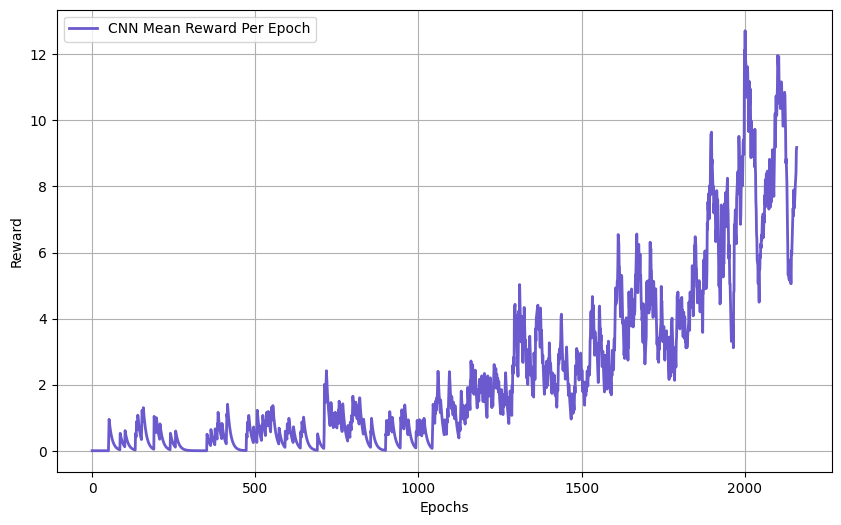

In [72]:
CNN_cramped_room_rewards = np.array(ff_agent_combined_state.get_layout_rewards()['cramped_room']) / EPISODES_PER_EPOCH

plt.figure(figsize=(10,6))
plt.plot(smooth(CNN_cramped_room_rewards), lw=2, color='slateblue', label="CNN Mean Reward Per Epoch")
#plt.plot(np.arange(1,len(CNN_cramped_room_rewards)+1), CNN_cramped_room_rewards, 'o', lw=1)
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

### FeedForward Neural Network with Value State Combined

In [30]:
policy_net_ff = build_policy_net(OBSERVATION_LENGTH)
value_net_ff = build_value_net(2*OBSERVATION_LENGTH)

ff_agent_value_combined_state = FFPPOValueCS( layouts=['cramped_room'], 
                                        self_play=True, 
                                        sparse_reward_decay_rate=sparse_reward_decay_rate,
                                        pi_net=policy_net_ff, 
                                        value_net=value_net_ff,
                                        deepcopy_function=deepcopy_ff_net,
                                        save_test=False
                                    )

In [31]:
ff_agent_value_combined_state.train(epochs=EXP_EPOCHS*6, 
                                 steps=EXP_STEPS, 
                                 batch_size=EXP_BATCH_SIZE, 
                                 pi_net_opt=AdamW(policy_lr), 
                                 value_net_opt=AdamW(value_lr),
                                 verbose=True
                                )

Starting epoch 1
policy loss: 0.027547186240553856, value loss: 0.2401253581047058, avg(|A|): 0.6515080332756042, max(|A|): 5.071005821228027, rollout reward: 0
Starting epoch 2
policy loss: -0.038473427295684814, value loss: 0.06624867022037506, avg(|A|): 0.8234438896179199, max(|A|): 3.2957611083984375, rollout reward: 0
Starting epoch 3
policy loss: -0.001963190734386444, value loss: 0.9742575883865356, avg(|A|): 0.654893696308136, max(|A|): 5.025914192199707, rollout reward: 0
Starting epoch 4
policy loss: -0.13356325030326843, value loss: 0.9679520726203918, avg(|A|): 0.5998113751411438, max(|A|): 5.9203715324401855, rollout reward: 0
Starting epoch 5
policy loss: -0.07752546668052673, value loss: 0.43620535731315613, avg(|A|): 0.6516609787940979, max(|A|): 4.685761451721191, rollout reward: 0
Starting epoch 6
policy loss: -0.006623229011893272, value loss: 0.24170079827308655, avg(|A|): 0.6921583414077759, max(|A|): 4.85837459564209, rollout reward: 0
Starting epoch 7
policy loss

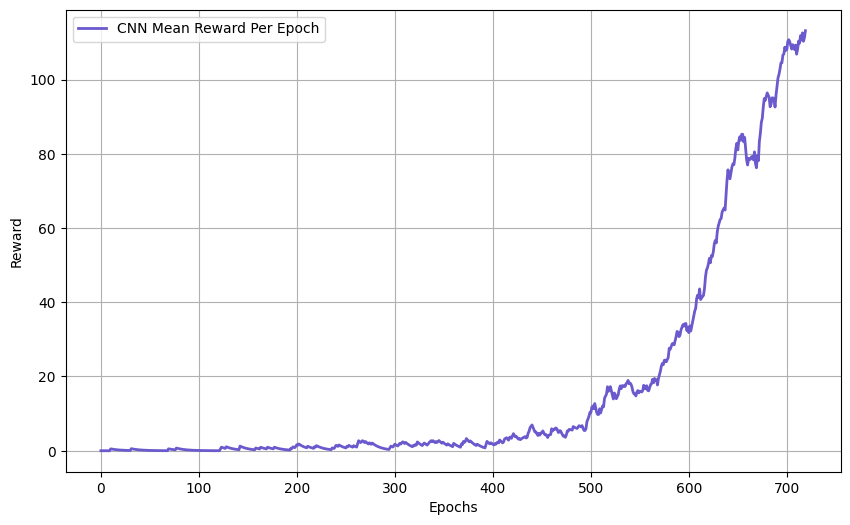

In [33]:
combined_value_cramped_room_rewards = np.array(ff_agent_value_combined_state.get_layout_rewards()['cramped_room']) / EPISODES_PER_EPOCH

plt.figure(figsize=(10,6))
plt.plot(smooth(combined_value_cramped_room_rewards), lw=2, color='slateblue', label="CNN Mean Reward Per Epoch")
#plt.plot(np.arange(1,len(CNN_cramped_room_rewards)+1), CNN_cramped_room_rewards, 'o', lw=1)
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

### Convolutional Network w/o Combined States

In [52]:
policy_net_cnn = build_policy_CNN()
value_net_cnn = build_value_CNN()

cnn_agent_no_combined_state = CNNPPOnoCS( layouts=['cramped_room'], 
                                        self_play=True, 
                                        sparse_reward_decay_rate=sparse_reward_decay_rate,
                                        pi_net=policy_net_cnn, 
                                        value_net=value_net_cnn,
                                        deepcopy_function=deepcopy_CNN,
                                        save_test=False
                                    )

In [53]:
cnn_agent_no_combined_state.train(epochs=EXP_EPOCHS*18, 
                                 steps=EXP_STEPS, 
                                 batch_size=EXP_BATCH_SIZE, 
                                 pi_net_opt=AdamW(policy_lr), 
                                 value_net_opt=AdamW(value_lr),
                                 verbose=True
                                )

Starting epoch 1
policy loss: 0.10041244328022003, value loss: 0.08733654022216797, avg(|A|): 0.46013855934143066, max(|A|): 7.7667365074157715, rollout reward: 0
Starting epoch 2
policy loss: -0.055580321699380875, value loss: 0.2699020206928253, avg(|A|): 0.5776481628417969, max(|A|): 5.597064971923828, rollout reward: 0
Starting epoch 3
policy loss: -0.0630606859922409, value loss: 0.2983027696609497, avg(|A|): 0.5807061195373535, max(|A|): 5.575078964233398, rollout reward: 0
Starting epoch 4
policy loss: -0.053481005132198334, value loss: 0.2558480203151703, avg(|A|): 0.5025700926780701, max(|A|): 6.746103286743164, rollout reward: 0
Starting epoch 5
policy loss: 0.07824641466140747, value loss: 0.46532177925109863, avg(|A|): 0.6898971796035767, max(|A|): 5.760829448699951, rollout reward: 0
Starting epoch 6
policy loss: 0.0035262182354927063, value loss: 0.399748295545578, avg(|A|): 0.615709662437439, max(|A|): 6.847324371337891, rollout reward: 0
Starting epoch 7
policy loss: -0

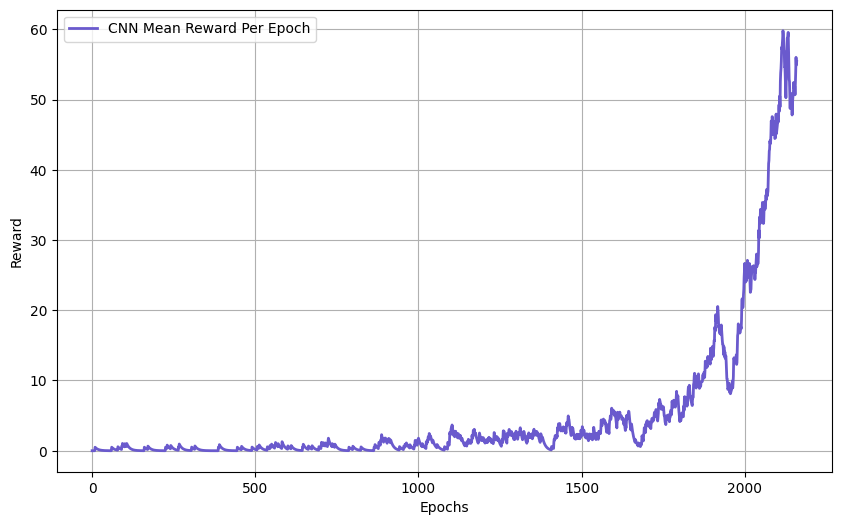

In [67]:
CNN_cramped_room_rewards = np.array(cnn_agent_no_combined_state.get_layout_rewards()['cramped_room']) / EPISODES_PER_EPOCH

plt.figure(figsize=(10,6))
plt.plot(smooth(CNN_cramped_room_rewards), lw=2, color='slateblue', label="CNN Mean Reward Per Epoch")
#plt.plot(np.arange(1,len(CNN_cramped_room_rewards)+1), CNN_cramped_room_rewards, 'o', lw=1)
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

In [70]:
policy_net_cnn.save_weights('policy_cnn.weights.h5')
value_net_cnn.save_weights('value_cnn.weights.h5')

# Best Architecture Generalized Partner

In [ ]:
best_policy_generalized_partner = build_policy_net(OBSERVATION_LENGTH)
best_value_generalized_partner = build_value_net(2*OBSERVATION_LENGTH)

best_agent_generalized_partner = FFPPOValueCS( layouts=['cramped_room'], 
                                                self_play=False, 
                                                sparse_reward_decay_rate=sparse_reward_decay_rate,
                                                pi_net=best_policy_generalized_partner, 
                                                value_net=best_value_generalized_partner,
                                                deepcopy_function=deepcopy_ff_net,
                                                save_test=True,
                                                train_agent_save_freq = 100,
                                                test_agent_save_freq = 110
                                            )

In [62]:
best_agent_generalized_partner.train(epochs=EXP_EPOCHS*6, 
                                    steps=EXP_STEPS, 
                                    batch_size=EXP_BATCH_SIZE, 
                                    pi_net_opt=AdamW(policy_lr), 
                                    value_net_opt=AdamW(value_lr),
                                    verbose=True
                                    )

Starting epoch 1
policy loss: -0.024660710245370865, value loss: 0.8700369000434875, avg(|A|): 0.7198264598846436, max(|A|): 5.055750846862793, rollout reward: 0
Starting epoch 2
policy loss: -0.006804755888879299, value loss: 0.3409463167190552, avg(|A|): 0.6063663959503174, max(|A|): 7.07165002822876, rollout reward: 0
Starting epoch 3
policy loss: -0.07500337809324265, value loss: 0.524448573589325, avg(|A|): 0.624345600605011, max(|A|): 6.82694673538208, rollout reward: 0
Starting epoch 4
policy loss: -0.01199481450021267, value loss: 0.6520375609397888, avg(|A|): 0.5571240186691284, max(|A|): 6.334253787994385, rollout reward: 0
Starting epoch 5
policy loss: 0.018057288601994514, value loss: 0.37650176882743835, avg(|A|): 0.6226010918617249, max(|A|): 5.047933578491211, rollout reward: 0
Starting epoch 6
policy loss: -0.11393658816814423, value loss: 1.3946919441223145, avg(|A|): 0.7049071788787842, max(|A|): 4.407151222229004, rollout reward: 0
Starting epoch 7
policy loss: -0.01

# Best Architecture Generalized Partner + Generalized Layout

In [ ]:
best_policy_generalized = build_policy_net(OBSERVATION_LENGTH)
best_value_generalized = build_value_net(2*OBSERVATION_LENGTH)
layouts = ["cramped_room", "asymmetric_advantages", "counter_circuit_o_1order"]

best_agent_generalized = FFPPOValueCS( layouts=layouts, 
                                        self_play=True, 
                                        sparse_reward_decay_rate=sparse_reward_decay_rate,
                                        pi_net=best_policy_generalized, 
                                        value_net=best_value_generalized,
                                        deepcopy_function=deepcopy_ff_net,
                                        save_test=True #,
                                        #train_agent_save_freq = 100,
                                        #test_agent_save_freq = 110
                                    )

In [ ]:
best_agent_generalized.train(epochs=EXP_EPOCHS*12, 
                                steps=EXP_STEPS, 
                                batch_size=EXP_BATCH_SIZE, 
                                pi_net_opt=AdamW(policy_lr), 
                                value_net_opt=AdamW(value_lr),
                                verbose=True
                                )

Starting epoch 1
policy loss: -0.11172144114971161, value loss: 0.07691756635904312, avg(|A|): 0.8085798621177673, max(|A|): 4.02910041809082, rollout reward: 0
Starting epoch 2
policy loss: 0.08131998777389526, value loss: 0.10242576152086258, avg(|A|): 0.7620120048522949, max(|A|): 4.363783359527588, rollout reward: 0
Starting epoch 3
policy loss: -0.06190088018774986, value loss: 0.023180559277534485, avg(|A|): 0.770423948764801, max(|A|): 4.469157695770264, rollout reward: 0
Starting epoch 4
policy loss: -0.03726886212825775, value loss: 0.13172724843025208, avg(|A|): 0.5317937731742859, max(|A|): 8.625799179077148, rollout reward: 0
Starting epoch 5
policy loss: -0.018853044137358665, value loss: 0.4960624575614929, avg(|A|): 0.6913925409317017, max(|A|): 4.532405376434326, rollout reward: 0
Starting epoch 6
policy loss: 0.035419415682554245, value loss: 0.0243771243840456, avg(|A|): 0.8065690398216248, max(|A|): 3.671783208847046, rollout reward: 0
Starting epoch 7
policy loss: 0

: 

# 2 Layouts Self-Play Curriculum Learning

In [24]:
class PPOBestCurriculum(FFPPOValueCS):
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool,                 
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60):
        super().__init__(layouts, self_play, sparse_reward_decay_rate, pi_net, value_net, deepcopy_function, save_test, train_agent_save_freq, test_agent_save_freq)
        self.MIN_CRAMPED_REWARD = 120
        self.MIN_ASYMMETRIC_ADVANTAGE_REWARD = 100
        self.debug1 = True
        self.debug2 = True

        self.cramped_room_master = False
        self.asymmetric_advantage_master = False

        self.layouts_dist = [1,0]

    @override
    def chose_layout(self, last_reward, last_layout):
        if not self.cramped_room_master and last_reward > self.MIN_CRAMPED_REWARD:
            self.cramped_room_master = True
            self.layouts_dist = [0.33, 0.67]
        
        elif self.cramped_room_master \
                and last_layout == 'asymmetric_advantages' \
                    and not self.asymmetric_advantage_master \
                        and last_reward > self.MIN_ASYMMETRIC_ADVANTAGE_REWARD:
            self.asymmetric_advantage_master = True
            self.layouts_dist = [0.5, 0.5]

        return np.random.choice(self.layouts, p=self.layouts_dist)

In [ ]:
best_policy_curriculum = build_policy_net(OBSERVATION_LENGTH)
best_value_curriculum = build_value_net(2*OBSERVATION_LENGTH)
layouts = ["cramped_room", "asymmetric_advantages"]

best_agent_curriculum = PPOBestCurriculum( layouts=layouts, 
                                        self_play=True, 
                                        sparse_reward_decay_rate=sparse_reward_decay_rate,
                                        pi_net=best_policy_curriculum, 
                                        value_net=best_value_curriculum,
                                        deepcopy_function=deepcopy_ff_net,
                                        save_test=False
                                    )

In [48]:
best_agent_curriculum.train(epochs=EXP_EPOCHS*12, 
                                steps=EXP_STEPS, 
                                batch_size=EXP_BATCH_SIZE, 
                                pi_net_opt=AdamW(policy_lr), 
                                value_net_opt=AdamW(value_lr),
                                verbose=True
                                )

Starting epoch 1
policy loss: -0.06880731880664825, value loss: 0.6472803354263306, avg(|A|): 0.5878602862358093, max(|A|): 7.139713764190674, rollout reward: 0
Starting epoch 2
policy loss: 0.07766231149435043, value loss: 0.4980630576610565, avg(|A|): 0.6198331713676453, max(|A|): 5.956435203552246, rollout reward: 0
Starting epoch 3
policy loss: 0.02378920465707779, value loss: 0.4743482172489166, avg(|A|): 0.5593142509460449, max(|A|): 7.5306620597839355, rollout reward: 0
Starting epoch 4
policy loss: -0.018980395048856735, value loss: 0.08665920048952103, avg(|A|): 0.7821179032325745, max(|A|): 3.8067398071289062, rollout reward: 0
Starting epoch 5
policy loss: 0.08273980021476746, value loss: 0.20245146751403809, avg(|A|): 0.604733943939209, max(|A|): 5.753817558288574, rollout reward: 0
Starting epoch 6
policy loss: -0.09210339933633804, value loss: 0.6291151642799377, avg(|A|): 0.6587103009223938, max(|A|): 7.0109429359436035, rollout reward: 0
Starting epoch 7
policy loss: -0

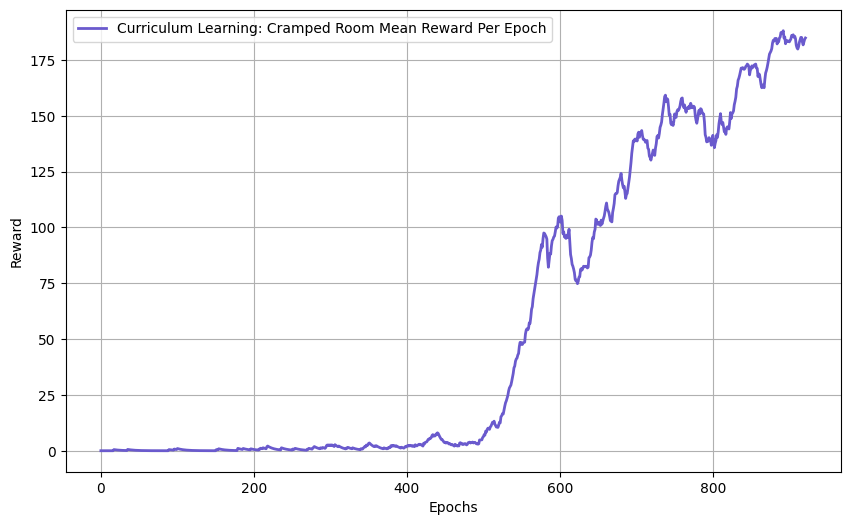

In [49]:
curriculum_cramped_room_rewards = np.array(best_agent_curriculum.get_layout_rewards()['cramped_room']) / EPISODES_PER_EPOCH

plt.figure(figsize=(10,6))
plt.plot(smooth(curriculum_cramped_room_rewards), lw=2, color='slateblue', label="Curriculum Learning: Cramped Room Mean Reward Per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

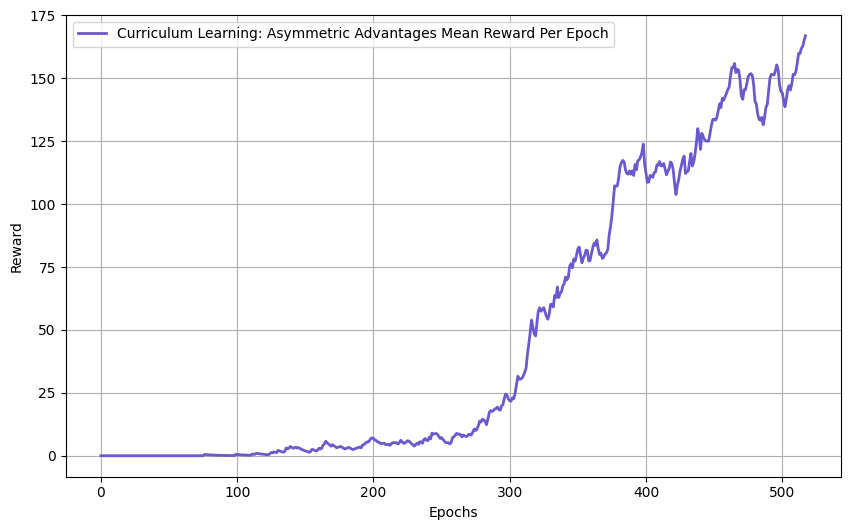

In [50]:
curriculum_asymmetric_advantages_rewards = np.array(best_agent_curriculum.get_layout_rewards()['asymmetric_advantages']) / EPISODES_PER_EPOCH

plt.figure(figsize=(10,6))
plt.plot(smooth(curriculum_asymmetric_advantages_rewards), lw=2, color='slateblue', label="Curriculum Learning: Asymmetric Advantages Mean Reward Per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

# 3-Layouts Self-Play Curriculum Learning

In [20]:
class PPOBestCurriculum_3layouts(FFPPOValueCS):
    def __init__(self, 
                 layouts:list[str], 
                 self_play:bool, 
                 sparse_reward_decay_rate: float,
                 pi_net:Functional, 
                 value_net:Functional,
                 deepcopy_function,
                 save_test:bool,                 
                 train_agent_save_freq = 50,
                 test_agent_save_freq = 60):
        super().__init__(layouts, self_play, sparse_reward_decay_rate, pi_net, value_net, deepcopy_function, save_test, train_agent_save_freq, test_agent_save_freq)
        self.MIN_CRAMPED_REWARD = 100
        self.MIN_ASYMMETRIC_ADVANTAGE_REWARD = 100
        self.MIN_COORDINATION_RING_REWARD = 100

        self.cramped_room_master = False
        self.asymmetric_advantage_master = False
        self.coordination_ring_master = False

        self.layouts_dist = [1,0,0]

    @override
    def chose_layout(self, last_reward, last_layout):
        if not self.cramped_room_master and last_reward > self.MIN_CRAMPED_REWARD:
            self.cramped_room_master = True
            self.layouts_dist = [0.33, 0.67, 0]
        
        elif self.cramped_room_master \
                and last_layout == 'asymmetric_advantages' \
                    and not self.asymmetric_advantage_master \
                        and last_reward > self.MIN_ASYMMETRIC_ADVANTAGE_REWARD:
            self.asymmetric_advantage_master = True
            self.layouts_dist = [0.2, 0.2, 0.6]
        
        elif self.cramped_room_master \
                and self.asymmetric_advantage_master \
                    and last_layout == 'coordination_ring' \
                        and not self.coordination_ring_master \
                            and last_reward > self.MIN_COORDINATION_RING_REWARD:
            self.coordination_ring_master = True
            self.layouts_dist = [0.33, 0.33, 0.34]

        return np.random.choice(self.layouts, p=self.layouts_dist)

In [21]:
best_policy_curriculum_3layouts = build_policy_net(OBSERVATION_LENGTH)
best_value_curriculum_3layouts = build_value_net(2*OBSERVATION_LENGTH)
layouts = ["cramped_room", "asymmetric_advantages", 'coordination_ring']

best_agent_curriculum_3layouts = PPOBestCurriculum_3layouts( layouts=layouts, 
                                                            self_play=True, 
                                                            sparse_reward_decay_rate=sparse_reward_decay_rate,
                                                            pi_net=best_policy_curriculum_3layouts, 
                                                            value_net=best_value_curriculum_3layouts,
                                                            deepcopy_function=deepcopy_ff_net,
                                                            save_test=False
                                                        )

In [22]:
best_agent_curriculum_3layouts.train(epochs=EXP_EPOCHS*18, 
                                    steps=EXP_STEPS, 
                                    batch_size=EXP_BATCH_SIZE, 
                                    pi_net_opt=AdamW(policy_lr), 
                                    value_net_opt=AdamW(value_lr),
                                    verbose=True
                                    )

Starting epoch 1
policy loss: -0.03594767302274704, value loss: 0.28221845626831055, avg(|A|): 0.596234917640686, max(|A|): 5.307201385498047, rollout reward: 0
Starting epoch 2
policy loss: -0.03652852401137352, value loss: 0.23755154013633728, avg(|A|): 0.6117828488349915, max(|A|): 5.3495378494262695, rollout reward: 0
Starting epoch 3
policy loss: -0.007108794525265694, value loss: 0.45717114210128784, avg(|A|): 0.6293364763259888, max(|A|): 6.878300666809082, rollout reward: 0
Starting epoch 4
policy loss: 0.05227452516555786, value loss: 0.13057000935077667, avg(|A|): 0.6181146502494812, max(|A|): 6.26333475112915, rollout reward: 0
Starting epoch 5
policy loss: -0.041094958782196045, value loss: 0.12857946753501892, avg(|A|): 0.6393259167671204, max(|A|): 7.047957897186279, rollout reward: 0
Starting epoch 6
policy loss: -0.16263151168823242, value loss: 0.4673236608505249, avg(|A|): 0.6733665466308594, max(|A|): 4.495981216430664, rollout reward: 0
Starting epoch 7
policy loss:

Continue Training

In [27]:
best_agent_curriculum_3layouts.train(epochs=EXP_EPOCHS*6, 
                                    steps=EXP_STEPS, 
                                    batch_size=EXP_BATCH_SIZE, 
                                    pi_net_opt=AdamW(policy_lr), 
                                    value_net_opt=AdamW(value_lr),
                                    verbose=True
                                    )

Starting epoch 1
policy loss: 0.03046833910048008, value loss: 2.357956886291504, avg(|A|): 0.3755541145801544, max(|A|): 9.593798637390137, rollout reward: 20
Starting epoch 2
policy loss: 0.012812444008886814, value loss: 62.32889175415039, avg(|A|): 0.7594459652900696, max(|A|): 4.550812244415283, rollout reward: 540
Starting epoch 3
policy loss: 0.025232313200831413, value loss: 66.44705963134766, avg(|A|): 0.7797167897224426, max(|A|): 4.50642204284668, rollout reward: 480
Starting epoch 4
policy loss: 0.06506779044866562, value loss: 68.13117218017578, avg(|A|): 0.7177343964576721, max(|A|): 3.882171869277954, rollout reward: 340
Starting epoch 5
policy loss: 0.06830531358718872, value loss: 0.015716053545475006, avg(|A|): 0.7530576586723328, max(|A|): 4.934406757354736, rollout reward: 0
Starting epoch 6
policy loss: -0.0683666318655014, value loss: 0.031443651765584946, avg(|A|): 0.7745105028152466, max(|A|): 5.648380279541016, rollout reward: 0
Starting epoch 7
policy loss: 0.

In [28]:
best_agent_curriculum_3layouts.weight = 0.3

In [29]:
best_agent_curriculum_3layouts.train(epochs=EXP_EPOCHS*6, 
                                    steps=EXP_STEPS, 
                                    batch_size=EXP_BATCH_SIZE, 
                                    pi_net_opt=AdamW(policy_lr), 
                                    value_net_opt=AdamW(value_lr),
                                    verbose=True
                                    )

Starting epoch 1
policy loss: -0.013254774734377861, value loss: 72.81224822998047, avg(|A|): 0.8128774762153625, max(|A|): 4.780370235443115, rollout reward: 540
Starting epoch 2
policy loss: 0.012296952307224274, value loss: 0.0563167929649353, avg(|A|): 0.6961288452148438, max(|A|): 5.937469005584717, rollout reward: 0
Starting epoch 3
policy loss: 0.06722941994667053, value loss: 0.04937068000435829, avg(|A|): 0.6646725535392761, max(|A|): 6.250923156738281, rollout reward: 0
Starting epoch 4
policy loss: 0.03569282591342926, value loss: 0.06300172209739685, avg(|A|): 0.6370844841003418, max(|A|): 5.521198272705078, rollout reward: 0
Starting epoch 5
policy loss: 0.014555006287992, value loss: 42.82354736328125, avg(|A|): 0.7109472751617432, max(|A|): 5.216071128845215, rollout reward: 460
Starting epoch 6
policy loss: 0.11594298481941223, value loss: 0.012684638611972332, avg(|A|): 0.48441940546035767, max(|A|): 8.038558959960938, rollout reward: 0
Starting epoch 7
policy loss: -0

In [30]:
best_agent_curriculum_3layouts.train(epochs=EXP_EPOCHS*6, 
                                    steps=EXP_STEPS, 
                                    batch_size=EXP_BATCH_SIZE, 
                                    pi_net_opt=AdamW(policy_lr), 
                                    value_net_opt=AdamW(value_lr),
                                    verbose=True
                                    )

Starting epoch 1
policy loss: -0.03137946128845215, value loss: 5.189660549163818, avg(|A|): 0.5052717328071594, max(|A|): 7.359954357147217, rollout reward: 40
Starting epoch 2
policy loss: 0.01588255912065506, value loss: 34.114173889160156, avg(|A|): 0.6996931433677673, max(|A|): 4.836939334869385, rollout reward: 460
Starting epoch 3
policy loss: 0.02367657981812954, value loss: 35.142356872558594, avg(|A|): 0.678630530834198, max(|A|): 5.081599235534668, rollout reward: 520
Starting epoch 4
policy loss: 0.0495753288269043, value loss: 50.68115234375, avg(|A|): 0.6113678216934204, max(|A|): 6.226844310760498, rollout reward: 700
Starting epoch 5
policy loss: -0.028439462184906006, value loss: 34.907958984375, avg(|A|): 0.7318362593650818, max(|A|): 4.843798637390137, rollout reward: 360
Starting epoch 6
policy loss: -0.09386871755123138, value loss: 8.70272445678711, avg(|A|): 0.6847444176673889, max(|A|): 4.867738246917725, rollout reward: 100
Starting epoch 7
policy loss: -0.0076

## Plotting Time!

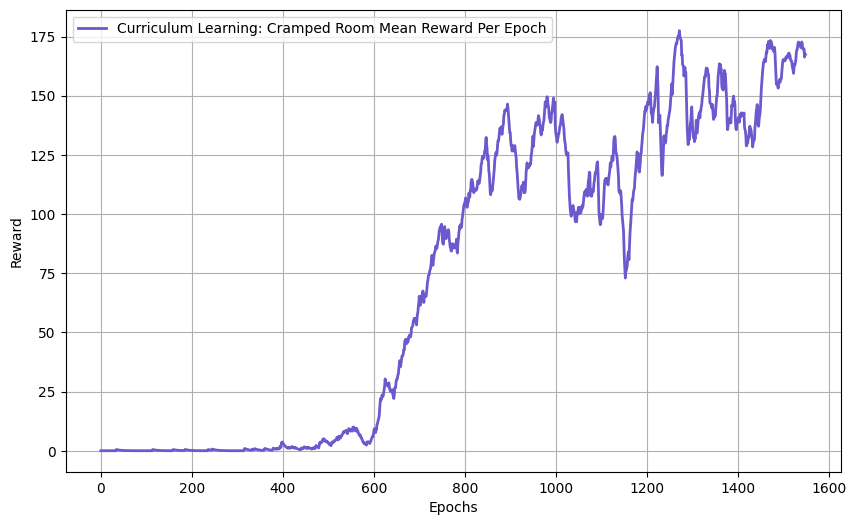

In [45]:
curriculum_cramped_room_rewards = np.array(best_agent_curriculum_3layouts.get_layout_rewards()['cramped_room']) / EPISODES_PER_EPOCH

plt.figure(figsize=(10,6))
plt.plot(smooth(curriculum_cramped_room_rewards), lw=2, color='slateblue', label="Curriculum Learning: Cramped Room Mean Reward Per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

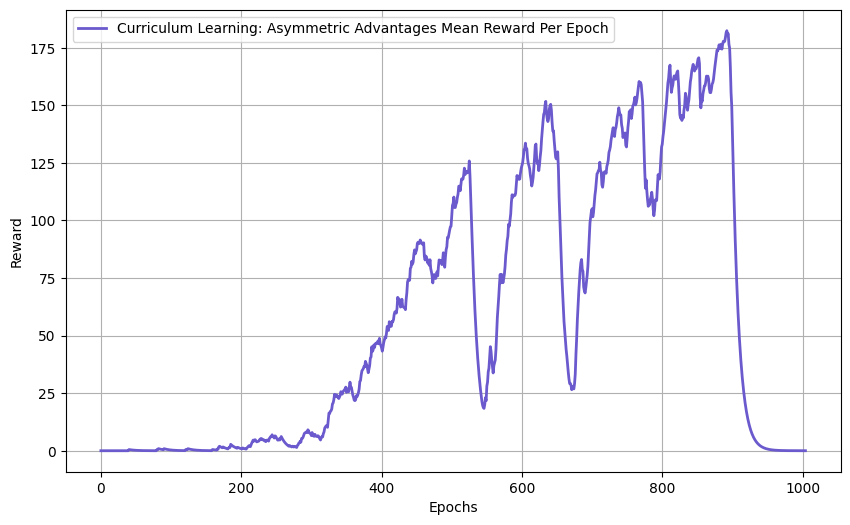

In [46]:
curriculum_cramped_room_rewards = np.array(best_agent_curriculum_3layouts.get_layout_rewards()['asymmetric_advantages']) / EPISODES_PER_EPOCH

plt.figure(figsize=(10,6))
plt.plot(smooth(curriculum_cramped_room_rewards), lw=2, color='slateblue', label="Curriculum Learning: Asymmetric Advantages Mean Reward Per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

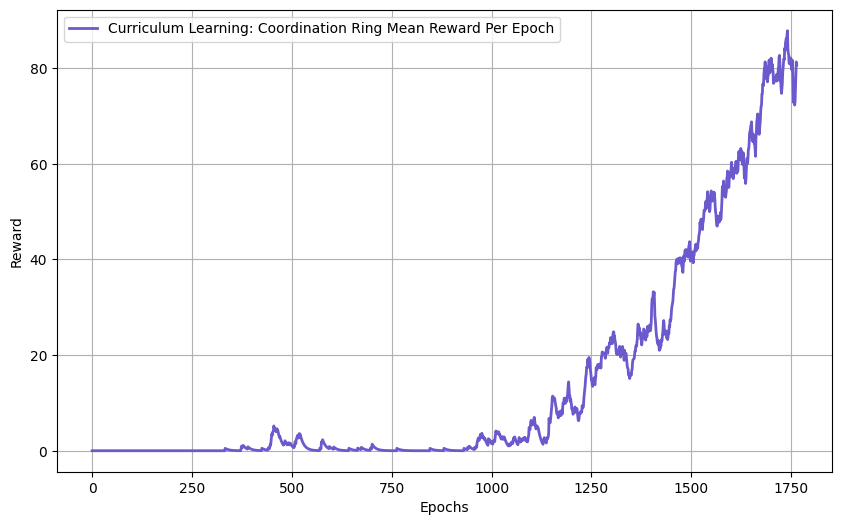

In [47]:
curriculum_cramped_room_rewards = np.array(best_agent_curriculum_3layouts.get_layout_rewards()['coordination_ring']) / EPISODES_PER_EPOCH

plt.figure(figsize=(10,6))
plt.plot(smooth(curriculum_cramped_room_rewards), lw=2, color='slateblue', label="Curriculum Learning: Coordination Ring Mean Reward Per Epoch")
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.grid()
plt.legend()
plt.show()

### Save Config

In [33]:
best_agent_curriculum_3layouts.pi_net.save_weights('3_layers_weights.weights.h5')

In [40]:
layout = "cramped_room"
base_mdp = OvercookedGridworld.from_layout_name(layout)
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=HORIZON)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True}, 
                                     env_params={"horizon": HORIZON})


self_play_policy = MyNNPolicy(best_agent_curriculum_3layouts.pi_net, base_env)
ap = AgentPair(AgentFromPolicy(self_play_policy), AgentFromPolicy(self_play_policy))

trajs = ae.evaluate_agent_pair(ap, 10)
StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

  0%|          | 0/10 [00:00<?, ?it/s]

Avg rew: 182.00 (std: 6.00, se: 1.90); avg len: 400.00; : 100%|██████████| 10/10 [04:04<00:00, 24.49s/it]


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…

In [ ]:
layout = "coordination_ring"
base_mdp = OvercookedGridworld.from_layout_name(layout)
base_env = OvercookedEnv.from_mdp(base_mdp, info_level=0, horizon=HORIZON)
env = Overcooked(base_env=base_env, featurize_fn=base_env.featurize_state_mdp)
ae = AgentEvaluator.from_layout_name(mdp_params={"layout_name": layout, "old_dynamics": True}, 
                                     env_params={"horizon": HORIZON})


self_play_policy = MyNNPolicy(best_agent_curriculum_3layouts.pi_net, base_env)
ap = AgentPair(AgentFromPolicy(self_play_policy), AgentFromPolicy(self_play_policy))

trajs = ae.evaluate_agent_pair(ap, 10)
StateVisualizer().display_rendered_trajectory(trajs, ipython_display=True)

Avg rew: 96.00 (std: 14.97, se: 4.73); avg len: 400.00; : 100%|██████████| 10/10 [04:12<00:00, 25.26s/it]


interactive(children=(IntSlider(value=0, description='timestep', max=399), Output()), _dom_classes=('widget-in…